In [1]:
from shapes import Point, Rectangle
from environment import Environment2D
from utils import PlotTools, GeoTools
from graph import Graph
from lqr import LQRPlanner
from simulate import Simulator
from plan import Plan, PlanUtils
from search import Searcher

from bitarray import bitarray, frozenbitarray
import time
import matplotlib.pyplot as plt
import numpy as np
import polytope as pc
%load_ext autoreload
%autoreload 2

In [2]:
# def generate_waypoints(A, B, x_0, u_nom):
#     T = u_nom.shape[0]
#     x_nom = np.zeros((T, A.shape[0]))
#     x_nom[0] = x_0
#     for t in range(1, T):
#         x_nom[t] = np.dot(A, x_nom[t - 1]) + np.dot(B, u_nom[t - 1])
#     return x_nom

# Env 0

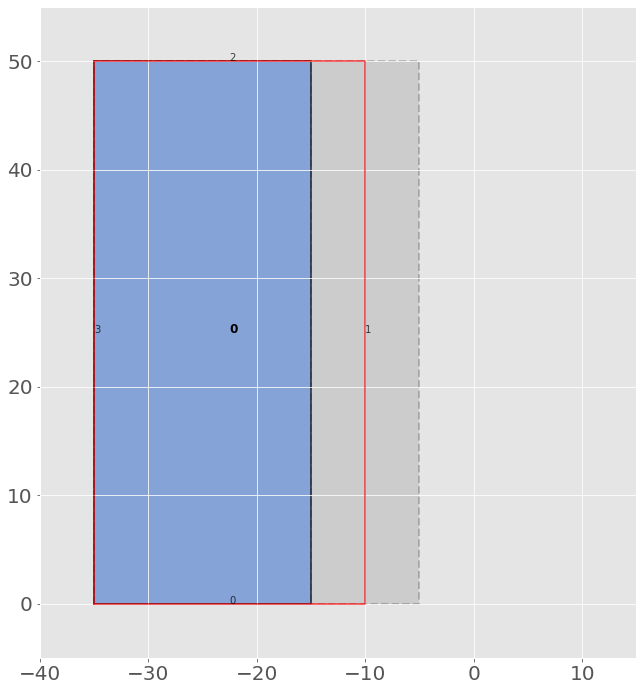

In [97]:
x_lims = [-40,15]
y_lims = [-5,55]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -35,0,25,50,0)
rec_0.set_error_bounds(np.array([0,-5,0,0]), np.array([0,5,0,0]))
rec_0.set_actual_errors(np.array([0,-5,0,0]))
# rec_0.set_actual_errors(np.array([0,5,0,0]))
fig, ax = plt.subplots()
env.add_rectangles([rec_0])
env.plot(ax=ax)
# env.rectangles[0].as_poly["actual"].plot(ax=ax)

In [105]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = np.eye(2)
R_lqr = 0.1*np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

dx = 1
Q = np.eye(2) * 0.05
R = 1
T = 50
x0 = [0,0]

x_est_0 = x0
P_est_0 = np.eye(2)

### Graph exploration

In [120]:
x_range = np.array([x_lims, y_lims])
nsamples = 100
tol = 1e-2
g = Graph(x0, x_range, env, lqr_planner)
g.clear()

In [122]:
samples_all = np.load("samples.dat", allow_pickle=True)
# samples_manual = []
# # # for i in [0,22,8,17,18,23,13,47,10,29,11]:
# for i in [0,8,18,13,47,10,29,11]:
#     samples_manual.append(samples_all[i,:2])
# samples_manual = np.array(samples_manual)
# g.set_samples(samples_manual)
g.set_samples(samples_all)

In [118]:
g.build(nsamples, r=10, max_neighbors=None, tol=tol)

Sampling took: 0.01 s.
Connecting took: 0.25 s.


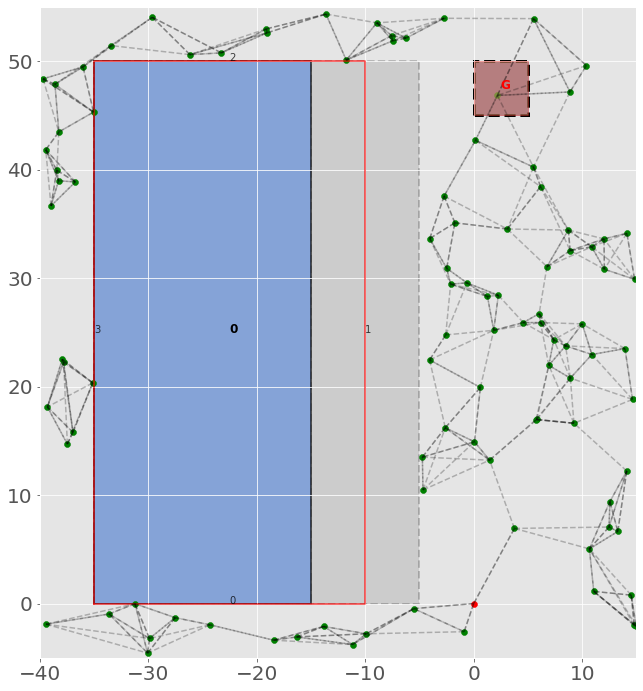

In [119]:
scaling_factors = [6,5,4,3,2,1]
fig, ax = plt.subplots()
goal_region = Rectangle(-1, 0,45,5,5,0)
g.plot(ax=ax, show_idx=False)
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)
# PlotTools.plot_traj(g.indices2path(plan_found.path_indices))
# plans_9[0].Xk_full.plot(ax=ax, scaling_factors=scaling_factors)
# Xks[0].plot(ax=ax, scaling_factors=scaling_factors)
# Xks_6[1].plot(ax=ax, scaling_factors=scaling_factors)
# plan_found.Xk_full.plot(ax=ax, scaling_factors=scaling_factors)

# config=bitarray('0100')
# env.rectangles[0].to_zonotope(frozenbitarray(config)).plot(ax=ax, scaling_factors=scaling_factors)

# list(searcher.P[2])[0].Xk_full.plot(ax=ax, scaling_factors=scaling_factors)
# list(searcher.P[2])[1].Xk_full.plot(ax=ax, scaling_factors=scaling_factors)
# Xk_full_dominated.plot(ax=ax, scaling_factors=scaling_factors)

In [31]:
horizon = 60
kmax = PlanUtils.get_kmax(dt, horizon)
lambda_coeff = 1.0
searcher = Searcher(g, lambda_coeff * g.r)
searcher.set_source()
searcher.initialize_open(Q, R, P_est_0, kmax)
searcher.set_goal(goal_region)

In [32]:
t1=time.time()
P_candidates, plan_found = searcher.explore(1.0)
print("Terminated in {} s.".format(time.time()-t1))

I have detected 4 cores, I am going to use 2
Done iteration 0
P_open has 5 plans.
P_open has 5 plans.
P has 5 plans.
Done iteration 1
num_open_plans = 16
Removed 2 plans in P_open.
----- Removed plans paths -----
[0, 38, 39]
cost * ratio = 136.79505192026434
[0, 32, 38]
cost * ratio = 169.45376108125782
-------------------------------
P_open has 14 plans.
P_open has 11 plans.
P has 7 plans.
Done iteration 2
num_open_plans = 27
Removed 3 plans in P_open.
----- Removed plans paths -----
[0, 39, 38]
cost * ratio = 136.7767969606376
[0, 39, 38, 43]
cost * ratio = 142.89619216958994
[0, 38, 28, 43]
cost * ratio = 173.78877380168498
-------------------------------
P_open has 24 plans.
P_open has 22 plans.
P has 13 plans.
Done iteration 3
num_open_plans = 65
Removed 7 plans in P_open.
----- Removed plans paths -----
[0, 32, 22, 30, 8]
cost * ratio = 105.26079582015934
[0, 43, 22, 30, 8]
cost * ratio = 106.91506468865111
[0, 38, 28, 31, 8]
cost * ratio = 108.54063286457988
[0, 38, 28, 9, 43]
c

TypeError: 'NoneType' object is not iterable

In [39]:
searcher.P[29]

set()

In [12]:
Xks = plan_found.get_Xks()

In [17]:
plan_found.Xk_full

### Simulation (for safety verification)

In [110]:
# x_noms = np.zeros((T,2))
# x_noms[:,1] = np.arange(0,T*dx, dx)
# u_noms = np.zeros((T,2))
# u_noms[:,1] = np.ones(T) * (dx/dt)

# path_indices = [0,2,4,6,7,8,9,10]
path_indices = [0,1,2,3,4,5,6,7]
x_noms, u_noms, scales = GeoTools.indices2traj(path_indices, 2, 2, g)

100%|██████████| 100/100 [00:04<00:00, 22.69it/s]


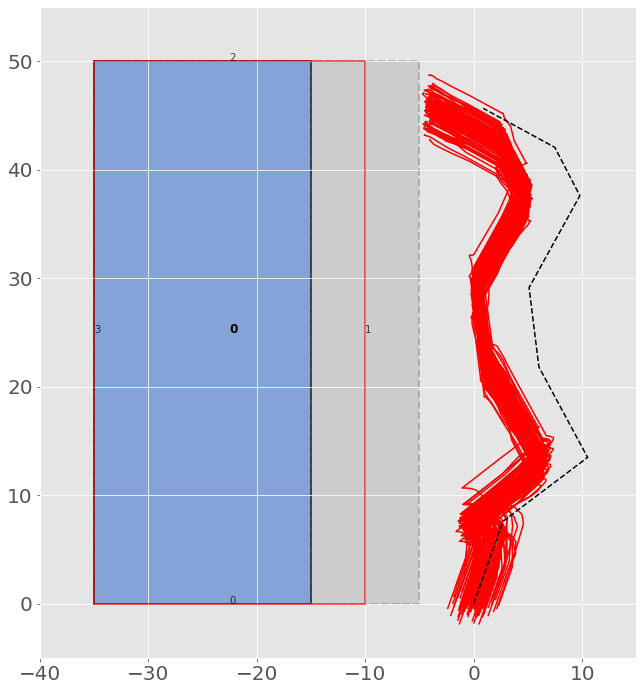

In [111]:
sim = Simulator(env)
sim.set_motion(A, B, Q)
sim.set_obs(R)
sim.set_gain(lqr_planner.gain)
sim.set_init_est(x_est_0, P_est_0)
num_iters = 100
xs, x_ests, x_bars, prob_collision = sim.run(num_iters, x0, P_est_0, x_noms, u_noms, scales)

env.plot()
Point(x0[0],x0[1]).plot()
sim.plot_trajs(xs, x_noms)

# Env 1

In [321]:
x_lims = [-10,10]
y_lims = [-5,5]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -6.5,-3,3,5,0)
rec_1 = Rectangle(1, 1,-1,3,3,0)
rec_2 = Rectangle(2, -10,5,20,1,0)
rec_3 = Rectangle(3, -10,-6.5,20,1,0)
rec_4 = Rectangle(4, -2.5,4.5,5,0.5,0)

rec_0.set_error_bounds(np.array([0,0,0,0]), np.array([0,1.5,1.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.5,0]))
rec_2.set_error_bounds(np.array([-0.5,0,0,0]), np.array([0.5,0,0,0]))

rec_0.set_actual_errors(np.array([0,0,1.5,0]))
rec_1.set_actual_errors(np.array([0,0,1.5,0]))
rec_2.set_actual_errors(np.array([-0.5,0,0,0]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3])
# env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4])
# env.add_rectangles([rec_0, rec_1, rec_3])

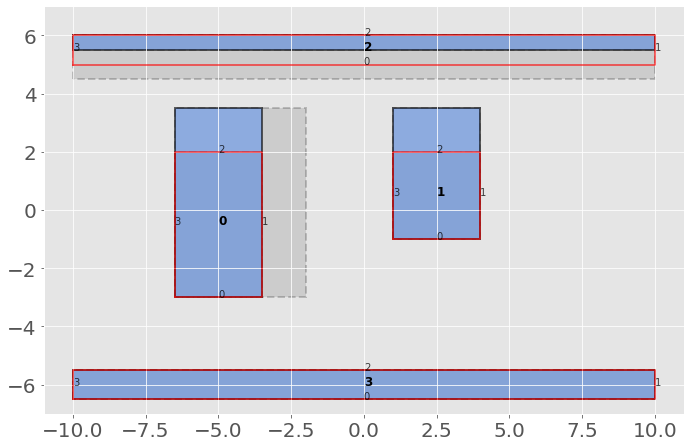

In [322]:
env.plot()

In [323]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = 10*np.eye(2)
R_lqr = np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

Q = np.eye(2) * 0.001
R = 0.1
T = 280
u_noms = np.zeros((T - 1, 2))
for t in range(T - 1):
    u_noms[t] = [0.3, 0]
x0 = [-9, 3.8]
x_noms = generate_waypoints(A, B, x0, u_noms)

x_est_0 = x0
P_est_0 = np.eye(2)

sim = Simulator(env)
sim.set_motion(A, B, Q)
sim.set_obs(R)
sim.set_gain(lqr_planner.lqr_gain)
sim.set_init_est(x_est_0, P_est_0)

In [324]:
# xs = sim.rollout(x0, x_noms, u_noms)

In [325]:
num_iters = 20
xs, x_ests, x_bars = sim.run(num_iters, x0, 0.0*np.eye(2), x_noms, u_noms)

100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


In [63]:
# sim.plot_trajs(xs, x_noms)

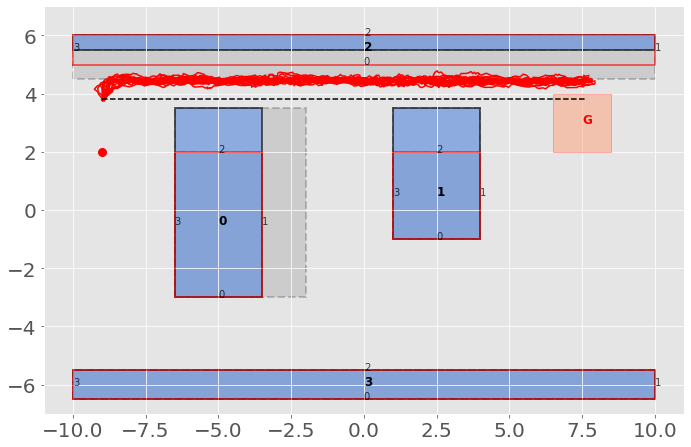

In [326]:
env.plot()
x_start = Point(-9, 2)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)
sim.plot_trajs(xs, x_noms)

# Env 2

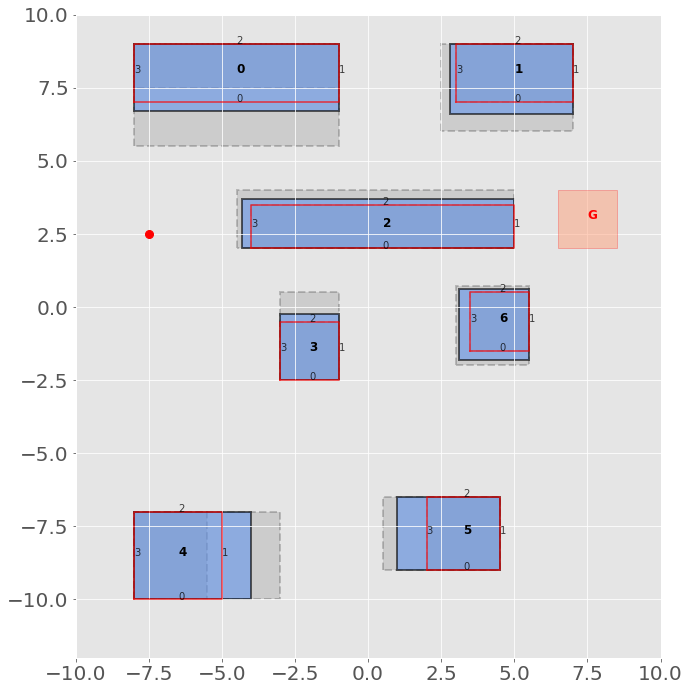

In [37]:
x_lims = [-10,10]
y_lims = [-12,10]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -8,7,7,2,0)
rec_1 = Rectangle(1, 3,7,4,2,0)
rec_2 = Rectangle(2, -4,2,9,1.5,0)
rec_3 = Rectangle(3, -3,-2.5,2,2,0)
rec_4 = Rectangle(4, -8,-10,3,3,0)
rec_5 = Rectangle(5, 2,-9,2.5,2.5,0)
rec_6 = Rectangle(6, 3.5,-1.5,2,2,0)

rec_0.set_error_bounds(np.array([-0.5,0,0,0]), np.array([1.5,0,0,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([1,0,0,0.5]))
rec_2.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0.5,0.5]))
rec_3.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1,0]))
rec_4.set_error_bounds(np.array([0,-0.5,0,0]), np.array([0,2,0,0]))
rec_5.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0,1.5]))
rec_6.set_error_bounds(np.array([0,0,0,0]), np.array([0.5,0,0.2,0.5]))

rec_0.set_actual_errors(np.array([0.3,0,0,0]))
rec_1.set_actual_errors(np.array([0.4,0,0,0.2]))
rec_2.set_actual_errors(np.array([0,0,0.2,0.3]))
rec_3.set_actual_errors(np.array([0,0,0.25,0]))
rec_4.set_actual_errors(np.array([0,1,0,0]))
rec_5.set_actual_errors(np.array([0,0,0,1]))
rec_6.set_actual_errors(np.array([0.3,0,0.1,0.4]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4, rec_5, rec_6])

env.plot()
x_start = Point(-7.5, 2.5)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)